In [4]:
import numpy as np
from dataloader import get_darcy_data_transformers
import matplotlib.pyplot as plt

from conditioningMaps import build_regression_problem
plt.style.use('ggplot')
from seaborn import kdeplot

from sklearn.datasets import make_moons
from data_generators import inf_train_gen
from sklearn.neighbors import KNeighborsRegressor

from scipy.stats import norm as scipy_normal

from scipy.interpolate import LinearNDInterpolator

import matplotlib.gridspec as gridspec

from scipy.stats import uniform
from sklearn.preprocessing import MinMaxScaler

In [5]:
class LinearInterp():
    def __init__(self):
        pass

    def fit(self,X,y):
        self.model = LinearNDInterpolator(X,y)
    
    def predict(self,X):
        return self.model(X)


def knn_weights(dist):
    return 1/(1e-5+dist**2)

In [6]:
class COT_model():
    def __init__(
            self, 
            conditioning_eps,
            dim_shared=1,
            dim_sample=1,
            extension_model = None,
            reference_RV = None
            ) -> None:
        """
        reference_RV should be a univariate distribution that is sampled iid for now
        """
        self.conditioning_eps = conditioning_eps
        self.dim_shared = dim_shared

        self.extension_model = extension_model
        if self.extension_model is None:
            self.extension_model = KNeighborsRegressor(n_neighbors = 2,weights='distance')
            
        self.reference_RV = reference_RV
        if self.reference_RV is None:
            self.reference_RV = scipy_normal(0,1)
        self.dim_sample = dim_sample
        self.np_generator = np.random.default_rng()
    
    def build_regression_problem(self,reference,target):
        reg_X,reg_y = build_regression_problem(
        reference,
        target,
        conditioning_eps = self.conditioning_eps,
        dim_shared = self.dim_shared,
        solver = 'lp'
        )
        return reg_X,reg_y
    
    def fit_extension_model(self,reg_X,reg_y):
        return self.extension_model.fit(reg_X,reg_y)
    
    def fit(self,target):
        reference = self.build_reference(target)
        reg_X,reg_y = self.build_regression_problem(reference,target)
        self.reg_X = reg_X
        self.reg_y = reg_y
        self.fit_extension_model(reg_X,reg_y)
        self.reference_cond = reference[:,:self.dim_shared]

    def build_reference(self,target):
        n = len(target)
        ycond = target[:,:self.dim_shared]
        vsamples = self.reference_RV.rvs(size = (n,self.dim_sample))
        return np.hstack([ycond,vsamples])
    
    def build_conditional_reference(self,yval,n):
        ycond = np.ones((n,self.dim_shared))@yval.reshape((1,-1))
        vsamples = self.reference_RV.rvs(size = (n,self.dim_sample))
        return np.hstack([ycond,vsamples])
    
    def get_conditional_samples(self,yval,n):
        reference = self.build_conditional_reference(yval,n)
        return self.extension_model.predict(reference)
    
    def sample_joint(self,n):
        ycond = self.np_generator.choice(self.reference_cond,n,replace = True)
        vsamples = self.reference_RV.rvs(size = (n,self.dim_sample))
        return np.hstack([ycond,self.extension_model.predict(np.hstack([ycond,vsamples]))])
    
    def eval_at_cond(self,yval,vvals):
        n = len(vvals)
        ycond = np.ones((n,self.dim_shared))@yval.reshape((1,-1))
        reference = np.hstack([ycond,vvals.reshape(n,self.dim_sample)])
        return self.extension_model.predict(reference)

def sample_true_cond(y,dataset,eps,preprocessor,num_samples,batch_size = 100000):
    eps = 0.01
    samples_true = preprocessor.transform(inf_train_gen(
        dataset,
        batch_size = num_samples
    ))
    true_cond = samples_true[np.abs(samples_true[:,0]-y)<=eps]
    while len(true_cond)<num_samples:
        samples_true = preprocessor.transform(inf_train_gen(
            dataset,
            batch_size = batch_size
        ))
        true_cond= np.vstack([true_cond,samples_true[np.abs(samples_true[:,0]-y)<=eps]])
    return true_cond[:num_samples]


In [7]:
preprocessor = MinMaxScaler((-1,1))

n = 20000
target = preprocessor.fit_transform(inf_train_gen(
    "pinwheel",
    batch_size = n
))

knn_model = KNeighborsRegressor(n_neighbors = 3,weights='distance')
linear_interp = LinearInterp()
cot_model = COT_model(
    0.005,
    dim_shared =1,
    dim_sample =1,
    extension_model = knn_model,
    reference_RV=scipy_normal(0,1)
)

cot_model.fit(target)

Building Cost Matrix
Solving OT Problem
Finished


In [8]:
yval_cond_points = np.array([-0.6,0,0.75])
colors = ['blue','red','black']
line_styles = ['-.','-',':']

joint_samples = cot_model.sample_joint(20000)
true_target = preprocessor.transform(inf_train_gen(
    "pinwheel",
    batch_size = 100000
))


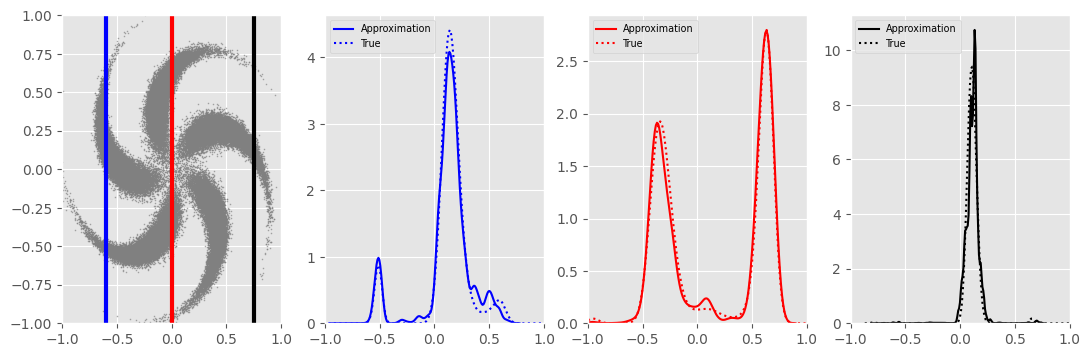

In [9]:
plt.figure(figsize=(13,4))

plt.subplot(1,4,1)
#plt.title(r"$\nu(y,u)$")
# plt.ylabel("u")
# plt.xlabel("y")
plt.scatter(true_target[:,0],true_target[:,1],s=0.5,alpha=0.5,c='grey')
for y,color,ls in zip(yval_cond_points,colors,line_styles):
    plt.plot([y,y],[-1,1],c=color,lw = 3)
plt.ylim(-1,1)
plt.xlim(-1,1)

for i in range(2,5):
    plt.subplot(1,4,i)
    y = yval_cond_points[i-2]
    color = colors[i-2]
    #plt.title("$T(y,\cdot) \sharp \eta(v\mid y)$")
    #plt.xlabel("v")
    # cond_samples = cot_model.get_conditional_samples(np.array([y]),50000)[:,0]
    cond_samples = cot_model.eval_at_cond(np.array([y]),scipy_normal().ppf(np.linspace(0,1,100000)[1:-1]))[:,0]
    kdeplot(cond_samples,bw_adjust=1,c=color,label = 'Approximation')

    true_cond = sample_true_cond(y,"pinwheel",0.01,preprocessor,100000,batch_size = 500000)
    kdeplot(true_cond[:,1],bw_adjust=1,c=color,label = 'True',ls = ':')
    plt.ylabel("")
    plt.xlim((-1,1))

    plt.legend(fontsize = 'x-small')

plt.savefig("figures/pinwheel_intro.png")
plt.show()


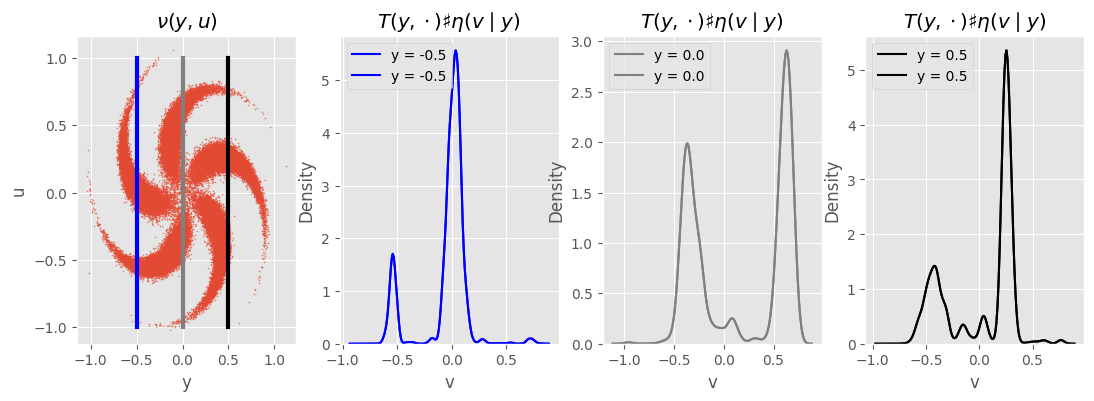

In [10]:
yval_cond_points = np.array([-0.5,0,0.5])
colors = ['blue','grey','black']
line_styles = ['-.','-',':']

joint_samples = cot_model.sample_joint(20000)
true_target = preprocessor.transform(inf_train_gen(
    "pinwheel",
    batch_size = 100000
))

plt.figure(figsize=(13,4))

plt.subplot(1,4,1)
plt.title(r"$\nu(y,u)$")
plt.ylabel("u")
plt.xlabel("y")
plt.scatter(true_target[:,0],true_target[:,1],s=0.5,alpha=0.5)
for y,color,ls in zip(yval_cond_points,colors,line_styles):
    plt.plot([y,y],[-1,1],c=color,lw = 3)

for i in range(2,5):
    plt.subplot(1,4,i)
    y = yval_cond_points[i-2]
    color = colors[i-2]
    ls = line_styles[i-2]
    plt.title("$T(y,\cdot) \sharp \eta(v\mid y)$")
    plt.xlabel("v")
    # cond_samples = cot_model.get_conditional_samples(np.array([y]),50000)[:,0]
    cond_samples = cot_model.eval_at_cond(np.array([y]),scipy_normal().ppf(np.linspace(0,1,100000)[1:-1]))[:,0]
    kdeplot(cond_samples,bw_adjust=0.9,c=color,label = f'y = {y}')
    kdeplot(cond_samples,bw_adjust=0.9,c=color,label = f'y = {y}') 
    plt.legend()

plt.show()



# plt.subplot(1,4,3)
# plt.title("$T(y,v)$")
# plt.xlabel("v")
# for y,color,ls in zip(yval_cond_points,colors,line_styles):
#     grid = np.linspace(-4,4,1000)
#     fval = cot_model.eval_at_cond(np.array([y]),grid)[:,0]
#     plt.plot(grid,fval,c=color,label = f'y = {y}',ls=ls)
#     plt.legend()
# plt.savefig("figures/pinwheel.png")


In [11]:
np.array([[]])

array([], shape=(1, 0), dtype=float64)

In [12]:
def build_example(dataset_name,reference,prefix='',num_train = 20000,preprocessor = None,vbounds = (0,1)):
    n = num_train
    target = preprocessor.transform(inf_train_gen(
        dataset_name,
        batch_size = n
    ))

    knn_model = KNeighborsRegressor(n_neighbors = 4,weights='distance')
    linear_interp = LinearInterp()
    cot_model = COT_model(
        0.005,
        dim_shared =1,
        dim_sample =1,
        extension_model = knn_model,
        reference_RV=reference
    )

    cot_model.fit(target)

    yval_cond_points = np.array([-0.3,0.4])
    colors = ['blue','black']
    line_styles = ['-.','-',':']

    #joint_samples = cot_model.sample_joint(20000)
    true_target = preprocessor.transform(inf_train_gen(
        dataset_name,
        batch_size = 100000
    ))

    plt.figure(figsize=(13,4))

    # Create a gridspec layout with 2 rows and 3 columns
    gs = gridspec.GridSpec(2, 3, width_ratios=[1, 1, 1], height_ratios=[1, 1])

    # Create subplots
    ax0 = plt.subplot(gs[:, 0])
    ax1 = plt.subplot(gs[0, 1])
    ax2 = plt.subplot(gs[1, 1])
    ax3 = plt.subplot(gs[:, 2])

    #ax0.set_title(r"$\nu(y,u)$")
    ax0.set_label("u")
    ax0.set_label("y")
    ax0.scatter(true_target[:,0],true_target[:,1],s=0.75,alpha=0.25)
    for y,color,ls in zip(yval_cond_points,colors,line_styles):
        ax0.plot([y,y],[-1,1],c=color,lw = 3)
    ax0.set_ylim(-1,1)


    
    y = yval_cond_points[0]
    color = colors[0]
    cond_samples = cot_model.get_conditional_samples(np.array([y]),50000)[:,0]
    kdeplot(cond_samples,bw_adjust=0.9,c=color,label = f'generated',ax=ax1)
    eps = 0.01
    true_cond = sample_true_cond(y,dataset_name,eps,preprocessor,50000,batch_size = 500000)
    kdeplot(true_cond[:,1],bw_adjust=1.,c=color,label = f'true',ls = ':',ax=ax1)
    #ax1.set_title("$T(y,\cdot) \sharp \eta(v\mid y), y=0.3$")
    #ax1.set_xlabel("v")
    ax1.set_ylabel("")
    ax1.set_xlim(-1,1)
    #ax1.legend()
    
    



    y = yval_cond_points[1]
    color = colors[1]
    cond_samples = cot_model.get_conditional_samples(np.array([y]),50000)[:,0]
    kdeplot(cond_samples,bw_adjust=1.,c=color,label = f'generated',ax=ax2)
    eps = 0.0025
    true_cond = sample_true_cond(y,dataset_name,eps,preprocessor,50000,batch_size = 500000)
    kdeplot(true_cond[:,1],bw_adjust=1.,c=color,label = f'true',ls = ':',ax=ax2)
    #ax2.legend()
    ax2.set_ylabel("")
    ax2.set_xlim(-1,1)
    #ax2.set_title("$T(y,\cdot) \sharp \eta(v\mid y), y=0.7$")
    #ax2.set_xlabel("v")


    #ax3.set_title("$T(y,v)$")
    #ax3.set_xlabel("v")
    for y,color,ls in zip(yval_cond_points,colors,line_styles):
        grid = np.linspace(vbounds[0],vbounds[1],1000)
        fval = cot_model.eval_at_cond(np.array([y]),grid)[:,0]
        ax3.plot(grid,fval,c=color,label = f'y = {y}')
    #ax3.legend()

    # Adjust layout
    plt.tight_layout()
    plt.savefig(f"figures/{prefix}_{dataset_name}.png")
    plt.show()

Building Cost Matrix
Solving OT Problem
Finished


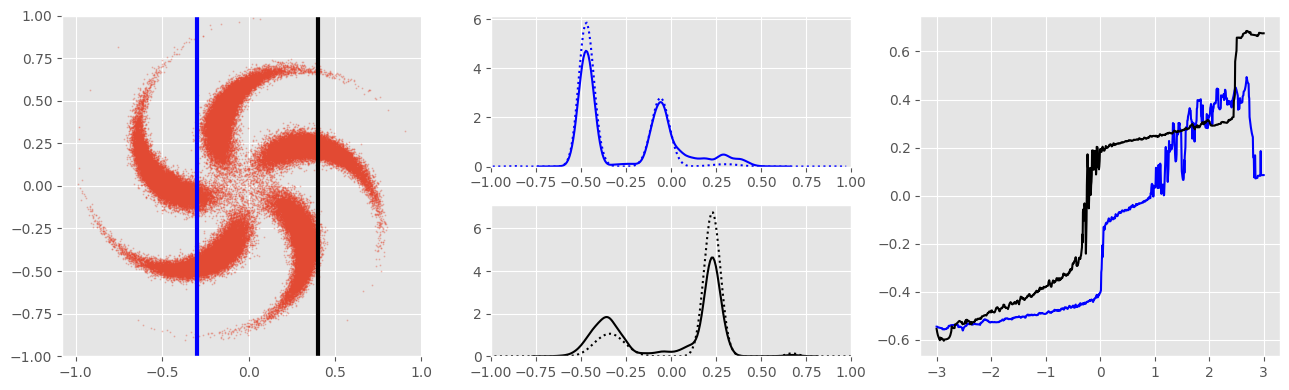

Building Cost Matrix
Solving OT Problem
Finished


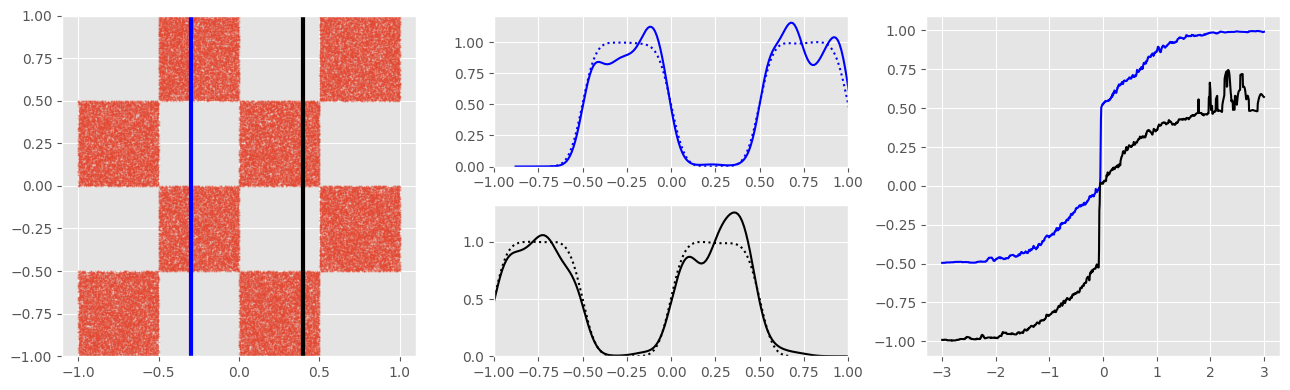

Building Cost Matrix
Solving OT Problem
Finished


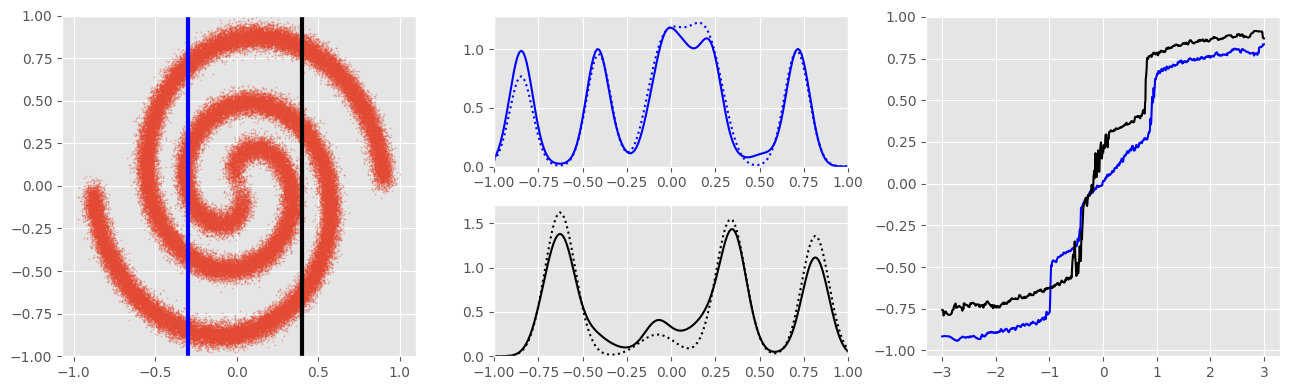

Building Cost Matrix
Solving OT Problem
Finished


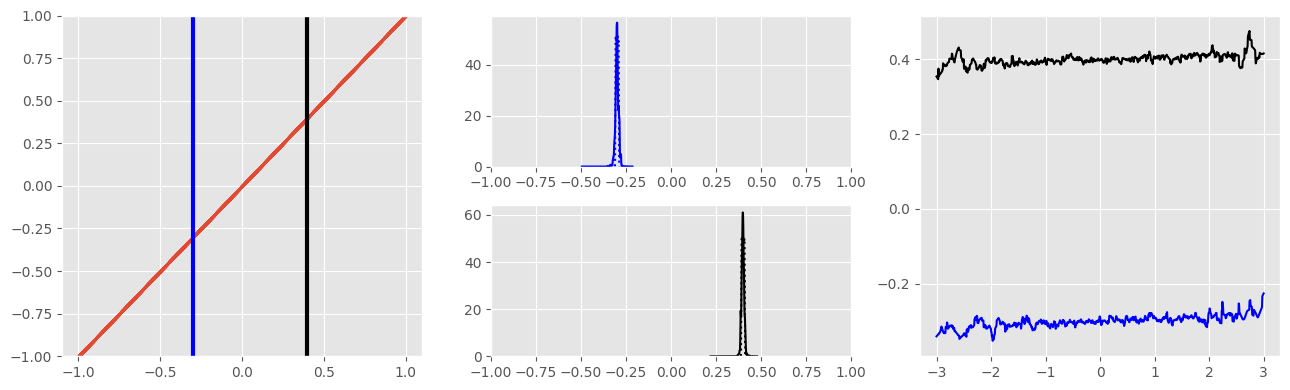

Building Cost Matrix
Solving OT Problem
Finished


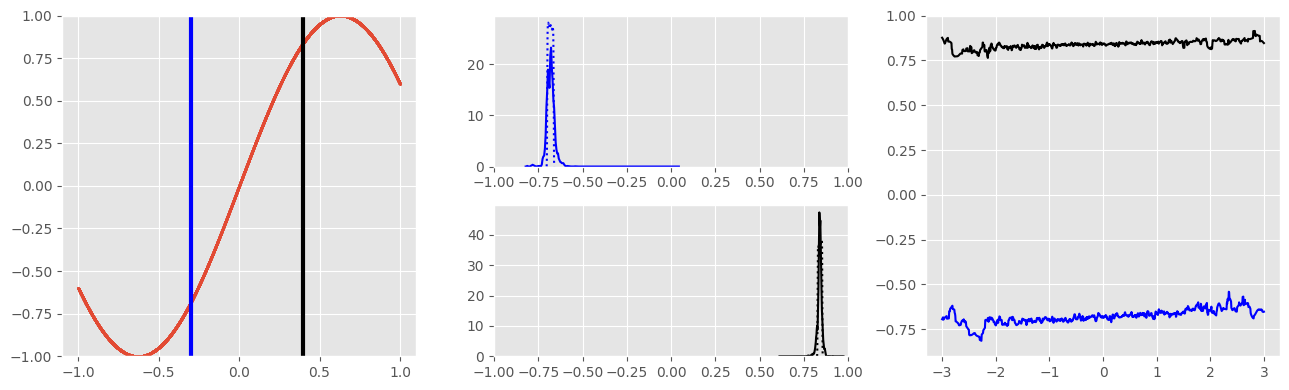

Building Cost Matrix
Solving OT Problem
Finished


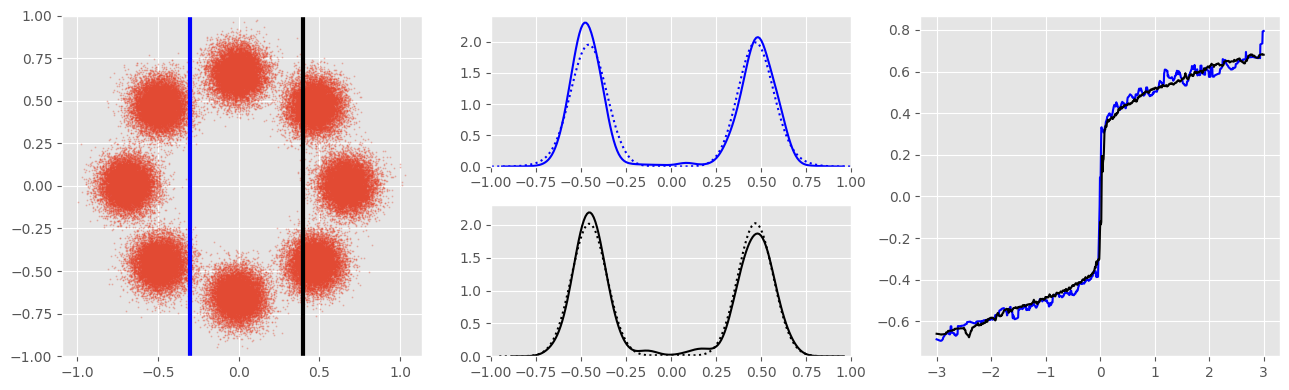

Building Cost Matrix
Solving OT Problem
Finished


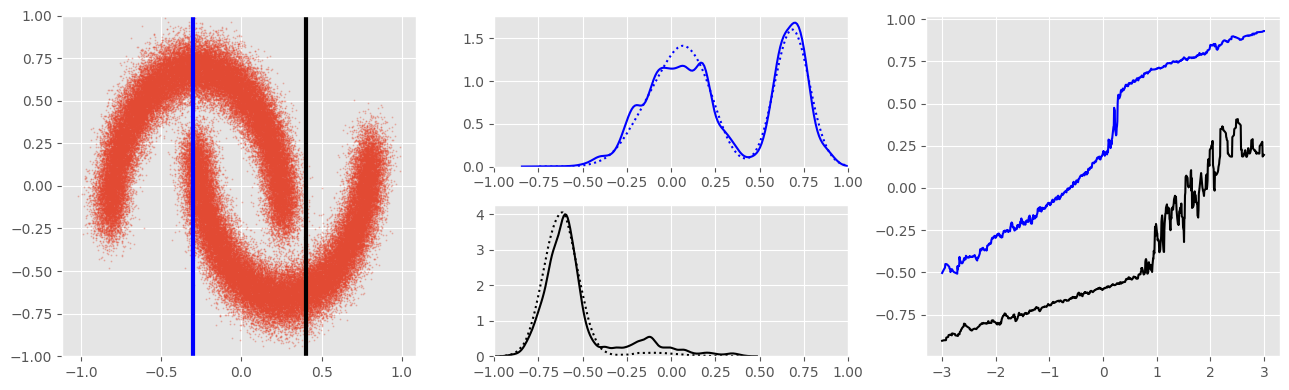

Building Cost Matrix
Solving OT Problem
Finished


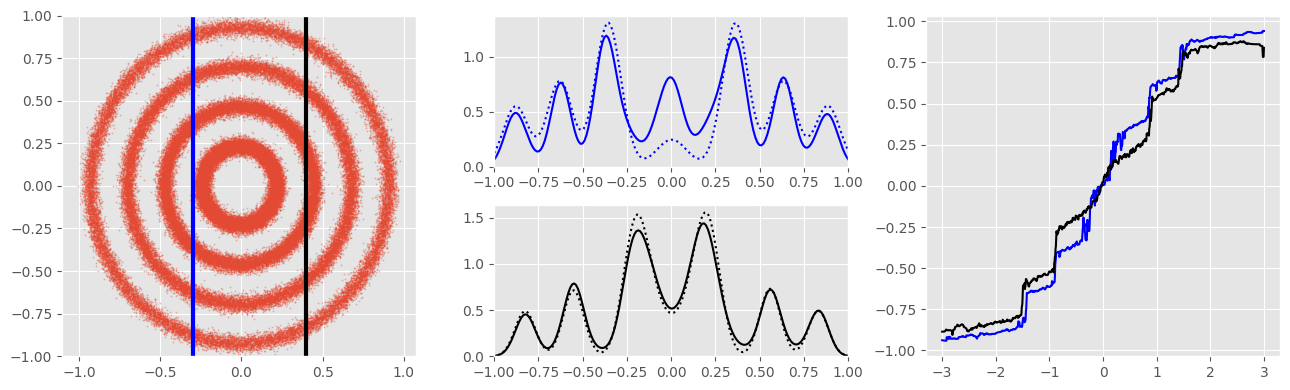

Building Cost Matrix
Solving OT Problem
Finished


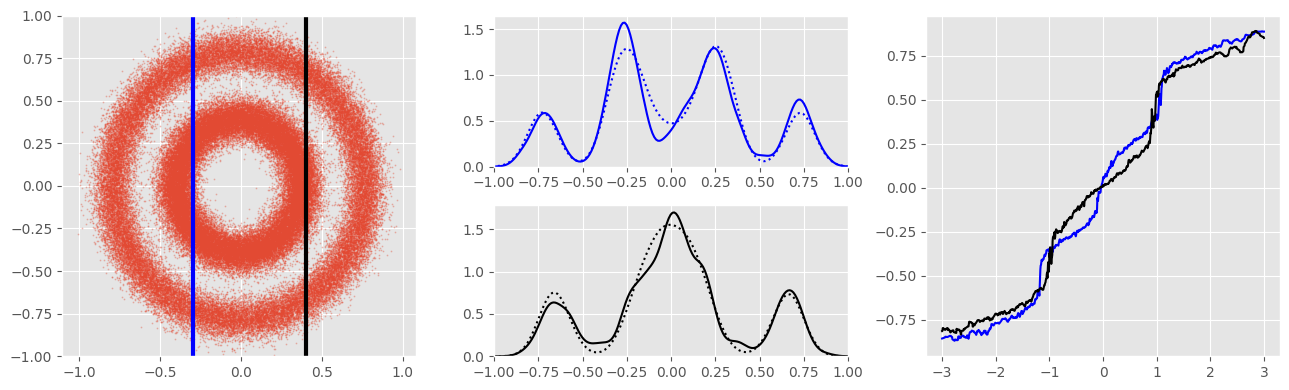

Building Cost Matrix
Solving OT Problem
Finished


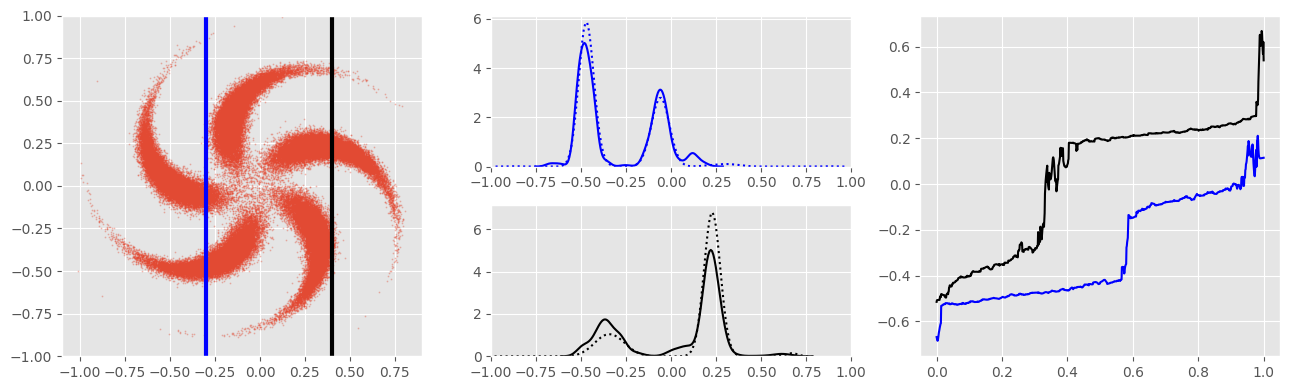

Building Cost Matrix
Solving OT Problem
Finished


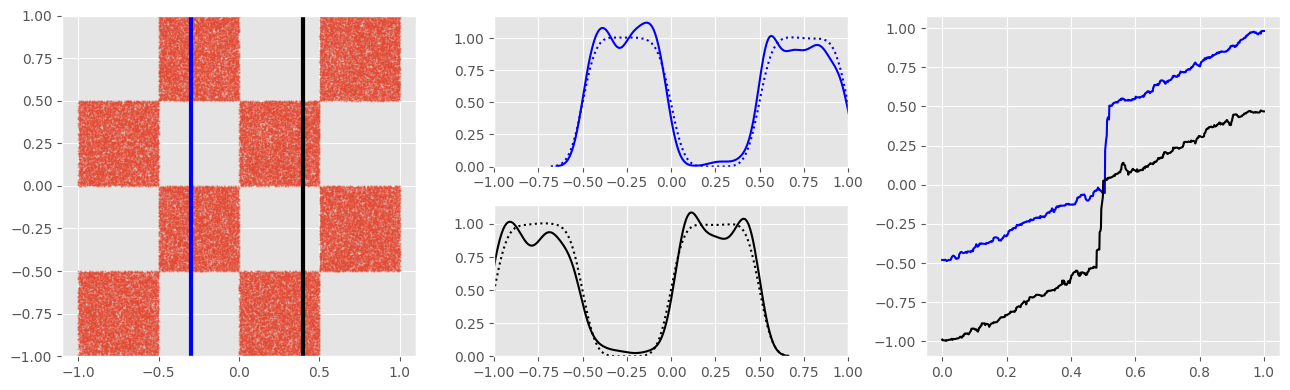

Building Cost Matrix
Solving OT Problem
Finished


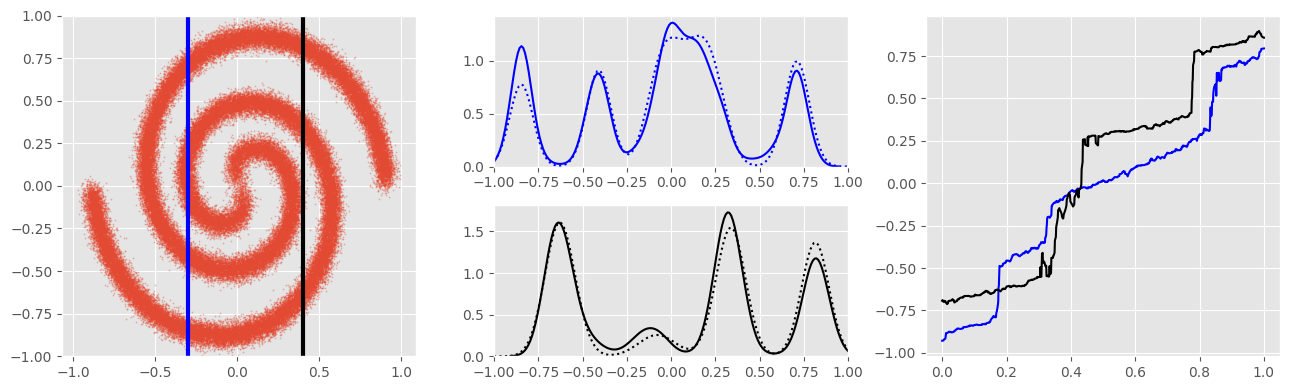

Building Cost Matrix
Solving OT Problem
Finished


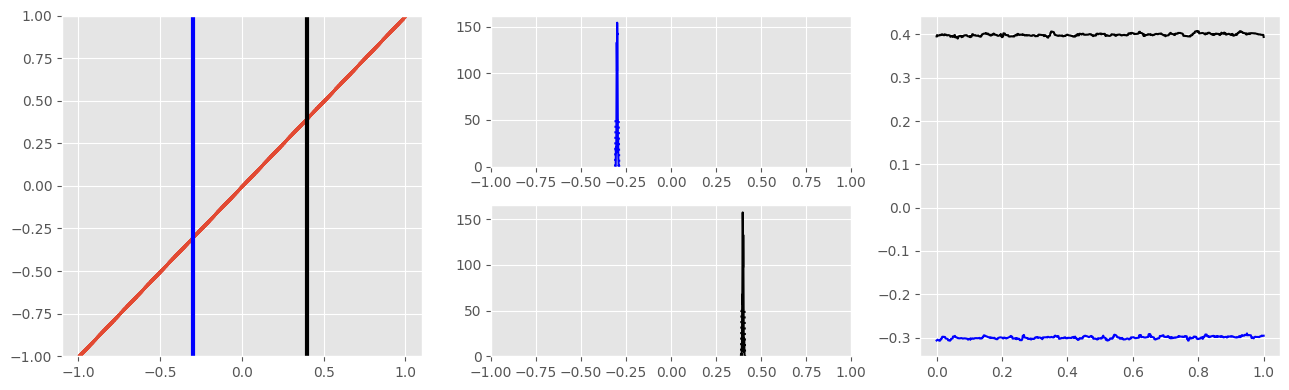

Building Cost Matrix
Solving OT Problem
Finished


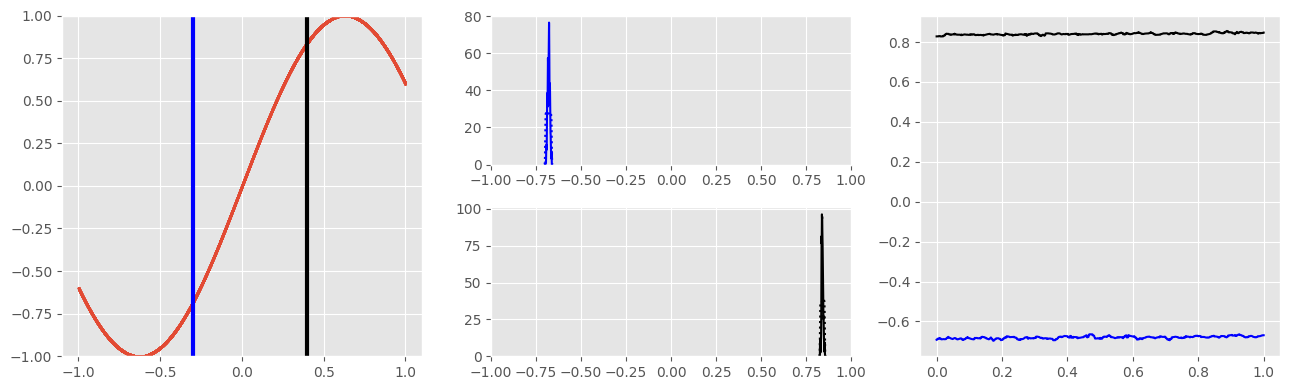

Building Cost Matrix
Solving OT Problem
Finished


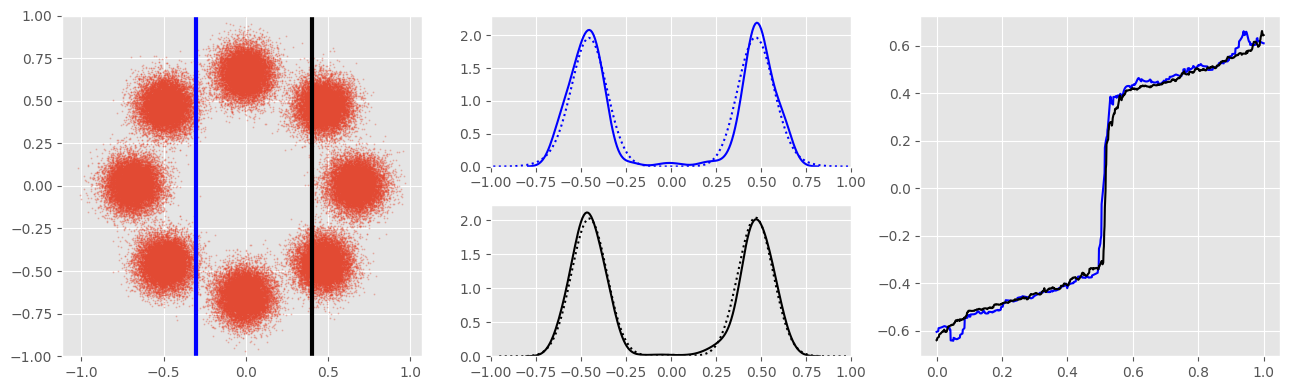

Building Cost Matrix
Solving OT Problem
Finished


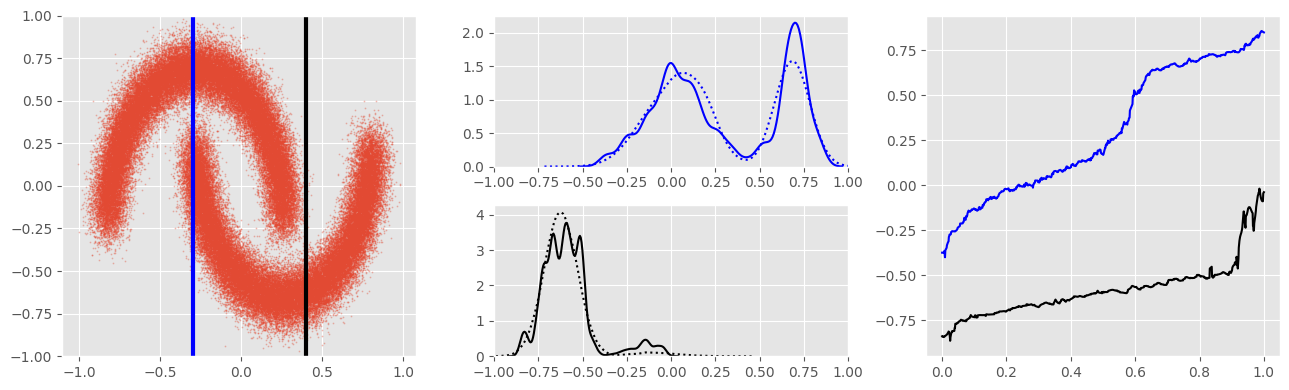

Building Cost Matrix
Solving OT Problem
Finished


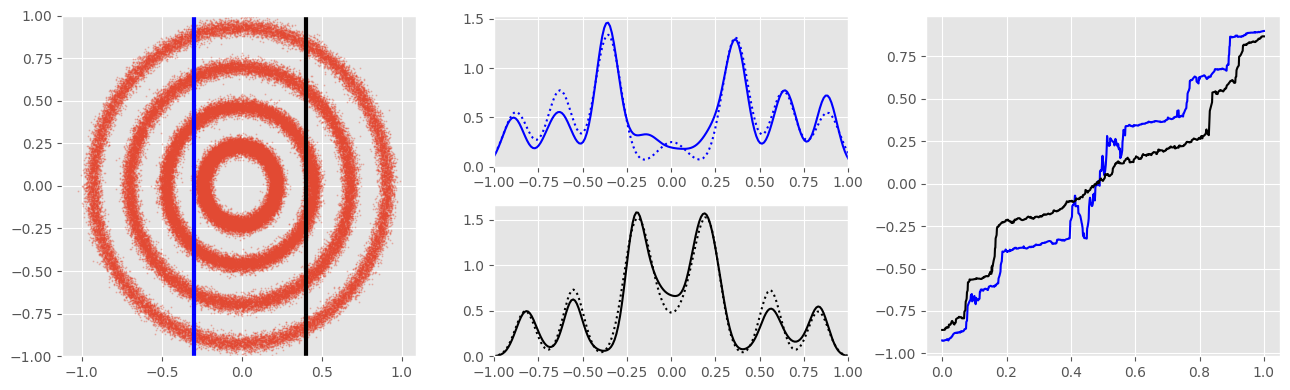

Building Cost Matrix
Solving OT Problem
Finished


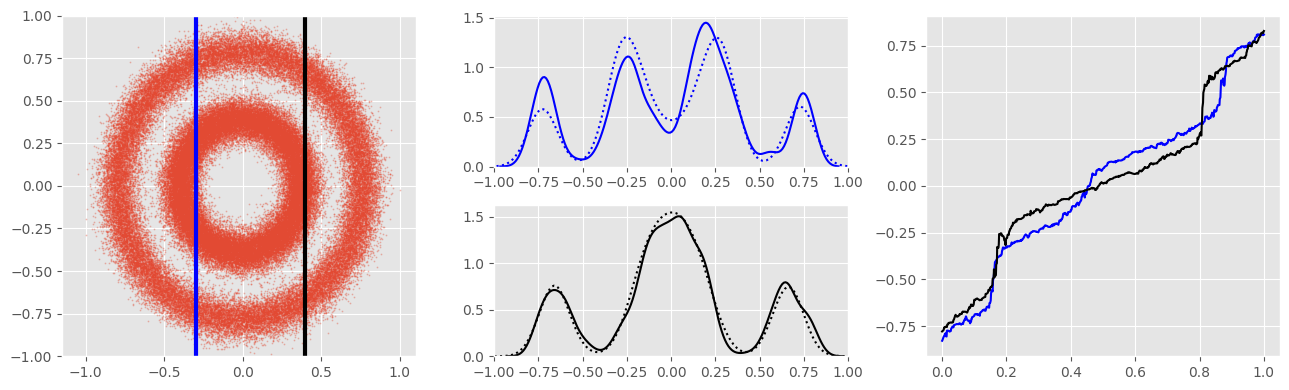

In [13]:
uniform_rv = uniform(0,1)
gaussian_rv = scipy_normal(0,1)

example_names = ["pinwheel","checkerboard","2spirals","line","cos","8gaussians","moons","rings","circles"]
#example_names = ["pinwheel"]
scalers = {
    dataset:MinMaxScaler((-1,1)).fit(inf_train_gen(
    dataset,
    batch_size = 100000
    )) for dataset in example_names
}


for dataset in example_names:
    build_example(dataset,gaussian_rv,'gaussian',20000,scalers[dataset],vbounds = (-3,3))

for dataset in example_names:
    build_example(dataset,uniform_rv,'uniform',20000,scalers[dataset])